# <p style="text-align:center">Lecture 4. E-Cell4における空間</p>

<p style="text-align:center;font-size:150%;line-height:150%">海津一成</p>

In [2]:
%matplotlib inline
from ecell4 import *

In [3]:
import seaborn
seaborn.set(font_scale=1.5)

## E-Cell4における空間

前回はE-Cell4における3つの要素`Model`、`World`、`Simulator`について説明した。また、常微分方程式ソルバである`ode`と確率論的手法である`gillespie`を用いて簡単な計算を試した。

`ode`や`gillespie`で計算を行なう際には容積を与えて`World`を作成したがE-Cell4における空間の取り扱いはどのようなものだろうか？

In [4]:
w1 = ode.ODEWorld(Real3(1, 1, 1))
w2 = gillespie.GillespieWorld(Real3(1, 1, 1))

`ode`と`gillespie`では上の例のように一辺が1の立方体の中で計算を行ったが実際にはその容積しか問題ではない。つまり、

In [6]:
w3 = ode.ODEWorld(Real3(2, 0.5, 1))  # is almost equivalent to 'w1'
w4 = gillespie.GillespieWorld(Real3(2, 2, 0.25))  # is almost equivalent to 'w2'

としても結局容積として1を与えるので同じ計算結果を示すだろう。

これは実際試験管内のように十分に攪拌され、空間的に均一な系では妥当に思える。

しかしながら、細胞内は明かに空間的に一様とは言えない。こうした分子の局在を考慮するためには空間を考慮した生化学計算が必要である。

E-Cell4では様々な空間表現やそれに対応した計算技法が利用可能である。

以下ではまずその内の1つである空間Gillespie法を例にE-Cell4における空間の取り扱いについて見ていく。

## 空間Gillespie法

E-Cell4で空間Gillespie法は`meso`モジュールに含まれている。まずは何も考えずに初級編で見たように`run_simulation`を用いて計算してみよう。

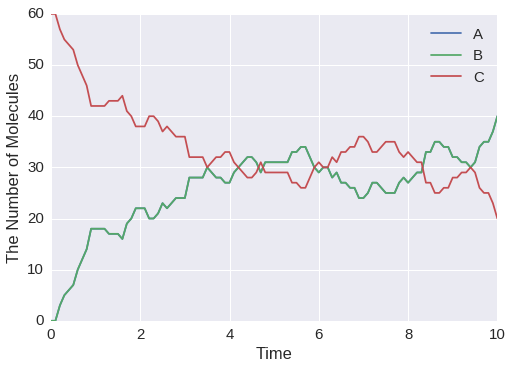

In [7]:
with reaction_rules():
    A + B == C | (0.01, 0.3)

y = run_simulation(10, {'C': 60}, solver='meso')